Status plot created


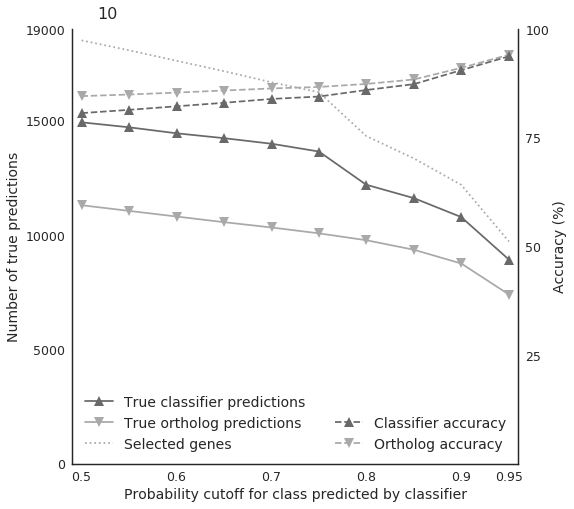

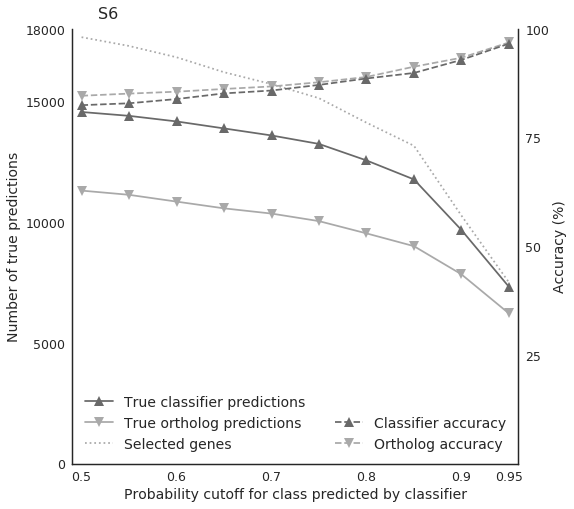

In [3]:
%matplotlib inline

import os as os
import numpy as np
import numpy.random as rng
import json as js
import csv as csv
import pickle as pck
import collections as col
import operator as op
import functools as fnt
import warnings as warn

import sklearn.exceptions as skle

warn.filterwarnings('error', message='Precision.+', category=skle.UndefinedMetricWarning)

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import mannwhitneyu as mwu

from sklearn.metrics import accuracy_score

# What is this?
# Plot model performance for different
# thresholds on prob of predicted class
# Includes ortholog performance on chosen subset

date = '20180314'

sns.set(style='white',
        font_scale=1.25,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis'
stat_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_summarize')
stat_file = os.path.join(stat_folder, 'agg_expstat_est.h5')
ortho_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_ortho_pred')
ortho_pred = os.path.join(ortho_folder, 'orthopred_odb_v9.h5')

cache_dir = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/caching/notebooks')

conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'
ref_folder = '/home/pebert/work/code/mpggit/refdata/annotation'

plot_labels = js.load(open(os.path.join(conf_folder, 'labels', 'cs_labels.json'), 'r'))
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))
plot_shapes = js.load(open(os.path.join(conf_folder, 'shapes', 'cs_shapes.json'), 'r'))
species_file = os.path.join(ref_folder, 'species.tsv')

run_exec_perf_comp = True

show_figures = True

out_folder = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/crossspecies/figures/pub'
save_figures = True

def exec_status():
    cache_data = os.path.join(cache_dir, '{}_plot_perfcomp_prob.h5'.format(date))
    fullmodel = 'can'
    comparison = 'pos'
    if os.path.isfile(cache_data):
        perf_scores = dict()
        with pd.HDFStore(cache_data, 'r') as hdf:
            for k in hdf.keys():
                lut_key = k.split('/')[1:]
                perf_scores[tuple(lut_key)] = hdf[k]            
    else:
        perf_scores = collect_performances(stat_file, ortho_pred, fullmodel, comparison)
        with pd.HDFStore(cache_data, 'w', complib='blosc', complevel=9) as hdf:
            for key, value in perf_scores.items():
                hdf.put('/'.join(key), value, format='table')

    spec_pairs = sorted(set([(k[0], k[1]) for k in perf_scores.keys()]))
    fig_keys = {('human', 'mouse'): ('10', 'main'),
                ('mouse', 'human'): ('S6', 'supp')}
    for trg, qry in spec_pairs:
        total_genes = perf_scores[(trg, qry, 'total', 'model')]
        total_ortho = perf_scores[(trg, qry, 'total', 'ortho')]
        total_genes = total_genes.max(axis=0).max()
        total_ortho = total_ortho.max(axis=0).max()
        
        sub_genes = perf_scores[(trg, qry, 'sub', 'model')]
        if sub_genes.shape[0] < 5:
            select_pred = (sub_genes == 0).any(axis=0)
            select_pred = ~select_pred
        else:
            select_pred = np.ones(sub_genes.shape[1]).astype(np.bool)
        
        sub_genes = sub_genes.median(axis=0)
        sub_genes = sub_genes[select_pred]
        
        yl_model = perf_scores[(trg, qry, 'true', 'model')]
        yl_model = yl_model.median(axis=0)
        yl_model = yl_model[select_pred]
        
        yl_ortho = perf_scores[(trg, qry, 'true', 'ortho')]
        yl_ortho = yl_ortho.median(axis=0)
        yl_ortho = yl_ortho[select_pred]
        
        left_values = [yl_model, yl_ortho]
        left_label = 'Number of true predictions'
        
        yr_model = perf_scores[(trg, qry, 'acc', 'model')]
        yr_model = yr_model.median(axis=0)
        yr_model = yr_model[select_pred]
                
        yr_ortho = perf_scores[(trg, qry, 'acc', 'ortho')]
        yr_ortho = yr_ortho.median(axis=0)
        yr_ortho = yr_ortho[select_pred]
        
        right_values = [yr_model, yr_ortho]
        right_label = 'Accuracy (%)'
        
        x_vals = np.array([int(c.split('_')[-1]) for c in yl_model.index], dtype=np.float16)
        x_vals /= 100.
        
        spec_color = plot_colors['species'][qry]['rgb']
        # removed species color here
        linecolors = ['dimgrey', 'darkgrey']
        linestyles = ['solid', 'dashed']
        linemarkers = ['^', 'v']
        linelabels = ['Classifier', 'Orthologs']
         
        plot_title = '{}-to-{} model'.format(trg, qry)
        
        if trg in ['human', 'mouse'] and qry in ['human', 'mouse']:
            fk, subfolder = fig_keys[(trg, qry)]
            plot_title = fk
            fig, exart = plot_perf_comp_lines(left_values, total_genes, right_values, x_vals, sub_genes,
                                              left_label, right_label, plot_title,
                                              linecolors, linestyles, linemarkers, linelabels)
            if save_figures:
                outname = 'fig_{}_{}-{}_testperf_prob'.format(fk, trg, qry)
                
                outpath = os.path.join(out_folder, subfolder, 'raw', outname + '.svg')
                fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
                
                outpath = os.path.join(out_folder, subfolder, 'png', outname + '.png')
                fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)
                
                outpath = os.path.join(out_folder, subfolder, outname + '.pdf')
                fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
                
    return True
   
    
def plot_perf_comp_lines(left_vals, left_max, right_vals, x_vals, sub_sizes,
                         left_label, right_label, title,
                         linecolors, linestyles, linemarkers, linelabels):
    """
    """
    fig, ax1 = plt.subplots(figsize=(8, 8))
    extra_artists = []
    ax1.set_xlim(x_vals.min() - 0.01, max(0.95, x_vals.max()) + 0.01)
    ax1.set_xlabel('Probability cutoff for class predicted by classifier', fontsize=14)
    rounded_max = int(left_max // 1000 * 1000 + 1000)
    yticks = list(range(0, rounded_max, 5000))
    yticks.append(rounded_max)
    ax1.set_yticks(yticks)
    ax1.set_ylim(0, rounded_max)
    ax1.set_ylabel(left_label, fontsize=14)
    ax1.spines['top'].set_visible(False)
    
    x_ticks_simple = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
    
    ax1.set_xticks(x_ticks_simple)
    ax1.set_xticklabels(list(map(str, x_ticks_simple)))
    
    handles = []
    left_model = ax1.plot(x_vals, left_vals[0].values, linestyle=linestyles[0],
                          color=linecolors[0], marker=linemarkers[0], markersize=10,
                          zorder=3, label='True classifier predictions')
    left_ortho = ax1.plot(x_vals, left_vals[1].values, linestyle=linestyles[0],
                          color=linecolors[1], marker=linemarkers[1], markersize=10,
                          zorder=2, label='True ortholog predictions')
    subset_size = ax1.plot(x_vals, sub_sizes.values, linestyle='dotted', color='darkgrey',
                           marker=None, label='Selected genes', zorder=1)
    handles.extend([left_model, left_ortho, subset_size])
    
    ax2 = ax1.twinx()
    ax2.set_ylim(0, 1)
    ax2.set_yticks([0.25, 0.5, 0.75, 1.])
    ax2.set_yticklabels(['25', '50', '75', '100'])
    ax2.set_ylabel(right_label, fontsize=14)
    ax2.spines['top'].set_visible(False)
    
    right_model = ax2.plot(x_vals, right_vals[0].values, linestyle=linestyles[1],
                          color=linecolors[0], marker=linemarkers[0], markersize=10,
                           zorder=3, label='Classifier accuracy')
    right_ortho = ax2.plot(x_vals, right_vals[1].values, linestyle=linestyles[1],
                           color=linecolors[1], marker=linemarkers[1], markersize=10,
                           zorder=2, label='Ortholog accuracy')
    handles.extend([right_model, right_ortho])
        
    ax1_handles, ax1_labels = ax1.get_legend_handles_labels()
    ax1_legend = ax1.legend(loc=3, fontsize=14)
    
    ax2_handles, ax2_labels = ax2.get_legend_handles_labels()
    ax2_legend = ax2.legend(loc=4, fontsize=14)
        
    tt = ax2.set_title(title, fontsize=16)
    tt.set_position([0.08, 1.01])
    return fig, extra_artists


def pair_model_ortholog_datasets(model_keys, ortho_keys):
    
    lut_okeys = dict()
    for ok in ortho_keys:
        parts = ok.split('/')
        source, target = parts[5].split('_'), parts[6].split('_')
        key = source[0], target[0]
        if key in lut_okeys:
            assert ok == lut_okeys[key], 'Dataset mismatch: {} / {}'.format(ok, lut_okeys[key])
        lut_okeys[key] = ok, parts[5], parts[6]
    
    key_pairs = []
    for mk in model_keys:
        parts = mk.split('/')
        source, target = parts[5].split('_'), parts[6].split('_')
        key = source[1], target[1]
        partner = lut_okeys[key]
        key_pairs.append((parts[3], parts[4], mk, partner[0], partner[1], partner[2]))
    return key_pairs
    

def compute_perf_scores(model_data, ortho_data, query_name, ortho_true, ortho_pred):
    
    lo_cols = sorted([c for c in model_data.columns if c.startswith('pred_prob_lo')],
                     key=lambda x: int(x.split('_')[-1]))
    assert query_name == model_data.index.name, 'Name mismatch: {} / {}'.format(query_name, mode_data.index.name)
    assert query_name in ortho_data.columns, 'Undefined query name: {} / {}'.format(query_name, ortho_data.columns)
    
    perf_index = ['acc', 'true', 'sub', 'total']
    
    model_perf = pd.DataFrame(np.zeros((4, len(lo_cols)), dtype=np.float32), 
                              index=perf_index,
                              columns=lo_cols)
    ortho_perf = pd.DataFrame(np.zeros((4, len(lo_cols)), dtype=np.float32), 
                              index=perf_index,
                              columns=lo_cols)
    total_model = model_data.shape[0]
    total_ortho = ortho_data.shape[0]
    for c in lo_cols:
        sub_model = model_data.loc[model_data[c] == 1, ['true_class', 'pred_class']]
        if sub_model.empty:
            model_perf[c] = pd.Series([0, 0, 0, total_model],
                                      index=perf_index)
            continue
        try:
            acc = accuracy_score(sub_model['true_class'], sub_model['pred_class'])
        except skle.UndefinedMetricWarning:
            # this can happen if there are no predictions for one label
            print('Model: UDM warning')
            model_perf[c] = pd.Series([0, 0, 0, total_model],
                                      index=perf_index)
            continue
        sub_size = sub_model.shape[0]
        true_pred = (sub_model['true_class'] == sub_model['pred_class']).sum()
        model_perf[c] = pd.Series([acc, true_pred, sub_size, total_model], index=perf_index)
        
        sub_ortho = ortho_data.loc[ortho_data[query_name].isin(sub_model.index), :]
        if sub_ortho.empty:
            ortho_perf[c] = pd.Series([0, 0, 0, total_ortho], index=perf_index)
            continue
        ortho_label_true = np.array(sub_ortho[ortho_true] >= 1, dtype=np.int8)
        ortho_label_pred = np.array(sub_ortho[ortho_pred] >= 1, dtype=np.int8)
        try:
            acc = accuracy_score(ortho_label_true, ortho_label_pred)
        except skle.UndefinedMetricWarning:
            print('Ortho: UDM warning')
            ortho_perf[c] = pd.Series([0, 0, 0, total_ortho], index=perf_index)
            continue
        sub_size = sub_ortho.shape[0]
        true_pred = (ortho_label_true == ortho_label_pred).sum()
        ortho_perf[c] = pd.Series([acc, true_pred, sub_size, total_ortho], index=perf_index)
    return model_perf, ortho_perf


def collect_performances(model_file, ortho_file, model_type, comparison):
    
    with pd.HDFStore(model_file, 'r') as model_hdf:
        filter_key = '/{}/{}'.format(comparison, model_type)
        model_keys = [k for k in model_hdf.keys() if k.startswith(filter_key) and k.endswith('/data')]
        with pd.HDFStore(ortho_file, 'r') as ortho_hdf:
            filter_key = '/{}/pair'.format(comparison, 'pair')
            ortho_keys = [k for k in ortho_hdf.keys() if k.startswith(filter_key) and k.endswith('/data')]
            
            key_pairs = pair_model_ortholog_datasets(model_keys, ortho_keys)
            collect_scores = dict()
            for trg, qry, model_key, ortho_key, ortho_pred, ortho_true in key_pairs:
                model_data = model_hdf[model_key]
                ortho_data = ortho_hdf[ortho_key]
                model_perf, ortho_perf = compute_perf_scores(model_data, ortho_data,
                                                             qry + '_name', ortho_true, ortho_pred)
                for label in model_perf.index:
                    if (trg, qry, label, 'model') in collect_scores:
                        old = collect_scores[(trg, qry, label, 'model')]
                        new = model_perf.loc[label, :].to_frame().transpose()
                        new.index = [0]
                        tmp = pd.concat([old, new], axis=0, ignore_index=True)
                        collect_scores[(trg, qry, label, 'model')] = tmp
                        
                        old = collect_scores[(trg, qry, label, 'ortho')]
                        new = ortho_perf.loc[label, :].to_frame().transpose()
                        new.index = [0]
                        tmp = pd.concat([old, new], axis=0, ignore_index=True)
                        collect_scores[(trg, qry, label, 'ortho')] = tmp
                    else:
                        tmp = model_perf.loc[label, :].to_frame().transpose()
                        tmp.index = [0]
                        collect_scores[(trg, qry, label, 'model')] = tmp
                        
                        tmp = ortho_perf.loc[label, :].to_frame().transpose()
                        tmp.index = [0]
                        collect_scores[(trg, qry, label, 'ortho')] = tmp
    return collect_scores


if run_exec_perf_comp:
    execd = exec_status()
    print('Status plot created')
